## FLAIR - NER

@inproceedings{akbik2019flair,
               title={FLAIR: An easy-to-use framework for state-of-the-art NLP},
               author={Akbik, Alan and Bergmann, Tanja and Blythe, Duncan and Rasul, Kashif and Schweter, Stefan and Vollgraf, Roland},
               booktitle={{NAACL} 2019, 2019 Annual Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations)},
               pages={54--59},
               year={2019}
}

To create a model that could find entities from the given piece of text, we first need to create a **training corpus**. Flair has a **specific structure** in which it expects the corpus to be. As per its documentation, it looks like:


George N B-PER 

Washington N I-PER

went V O

to P O 

Washington B B-LOC


The sentences in the corpus are separated by an empty line.
Each row(line) has three columns. The first column is the word, the second column is the corresponding POS tag and the final column denotes the BIO-annotated NER tag.
We need not have all these three columns, say we need to train the model to just predict the NER tags, we can omit the second column.
The important thing to note here is, that the datasets that are available within flair.datasets and the other sequence labeling datasets should be in the given format. If we are training for custom entities, we need to prepare that dataset on our own.

## DATA CREATION:
flair.datasets has this class called **ColumnCorpus** using which **we can create our corpus object**. As you see the arguments for it’s __init__ method, the three .txt files which correspond to train, test and validation corpora, have the data in the format we discussed above. columns is a dictionary where we define the columns in the text files.

Given that annotations are available in a certain format, the following piece of code could be modified as per the requirement. The following code is written assuming the data is in form of a pandas dataframe with two major columns, first being the actual text, the second is the annotation, that is a list of tuples, where the tuple has two elements, the first is the annotated text and the second is the corresponding label.
Ideally, the text should just be a sentence, if not(is a paragraph), any sentence tokenizer could be used, for example, spaCy’s sentence tokenizer to get the text to sentence level. 

The following code will create a .txt file for the data given, hence could be called thrice to create the train, test and validation data in the required input format. This will save the .txt at the given path.

In [1]:
import pandas as pd
from tqdm import tqdm
from difflib import SequenceMatcher
import re
import pickle

def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)
        
    return match_list, string

def mark_sentence(s, match_list):
    '''
    Marks all the entities in the sentence as per the BIO scheme. 
    '''
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'
        
    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def clean(text):
    '''
    Just a helper fuction to add a space before the punctuations for better tokenization
    '''
    filters = ["!", "#", "$", "%", "&", "(", ")", "/", "*", ".", ":", ";", "<", "=", ">", "?", "@", "[",
               "\\", "]", "_", "`", "{", "}", "~", "'"]
    for i in text:
        if i in filters:
            text = text.replace(i, " " + i)
            
    return text

def create_data(df, filepath):
    '''
    The function responsible for the creation of data in the said format.
    '''
    with open(filepath , 'w') as f:
        for text, annotation in zip(df.text, df.annotation):
            text = clean(text)
            text_ = text        
            match_list = []
            for i in annotation:
                a, text_ = matcher(text, i[0])
                match_list.append((a[0][0], a[0][1], i[1]))

            d = mark_sentence(text, match_list)

            for i in d.keys():
                f.writelines(i + ' ' + d[i] +'\n')
            f.writelines('\n')
            

## READING THE CORPUS
It is ready to load the corpus we have created and begin with the training. Let’s start with loading our corpus.
 

In [2]:
import flair
from flair.data import Corpus
from flair.datasets import ColumnCorpus

#get corpus and define columns

data_folder=r'C:\Users\Chiara\Desktop\CoNLL_project'

columns= {0:'text',1:'pos',2:"phrase",3:"ner"}

corpus: Corpus = ColumnCorpus(data_folder,columns,
                              train_file='train.txt',
                              test_file='test.txt',
                              dev_file='valid.txt')


2021-03-29 09:36:23,124 Reading data from C:\Users\Chiara\Desktop\CoNLL_project
2021-03-29 09:36:23,127 Train: C:\Users\Chiara\Desktop\CoNLL_project\train.txt
2021-03-29 09:36:23,127 Dev: C:\Users\Chiara\Desktop\CoNLL_project\valid.txt
2021-03-29 09:36:23,128 Test: C:\Users\Chiara\Desktop\CoNLL_project\test.txt


In [3]:
#Now that we have loaded our corpus, we can use this corpus object to get its information like:
print(len(corpus.train))

#print(corpus.train[50].to_tagged_string('pos'))
print(corpus.train[40].to_tagged_string('ner')) #50 is the number of the sentence that, for example, I want to analyse 

14987
-DOCSTART-


In [4]:
from flair.data import Sentence
from flair.models import SequenceTagger
from ipywidgets import IntProgress
# make a sentence
sentence = Sentence('I live in Paris')
tagger = SequenceTagger.load('ner')
tagger.predict(sentence)

2021-03-29 09:36:30,466 --------------------------------------------------------------------------------
2021-03-29 09:36:30,468 The model key 'ner' now maps to 'https://huggingface.co/flair/ner-english' on the HuggingFace ModelHub
2021-03-29 09:36:30,469  - The most current version of the model is automatically downloaded from there.
2021-03-29 09:36:30,470  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner/en-ner-conll03-v0.4.pt)
2021-03-29 09:36:30,471 --------------------------------------------------------------------------------
2021-03-29 09:36:31,245 loading file C:\Users\Chiara\.flair\models\ner-english\4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4


Named entity recognition is a task that is well-suited to the type of **classifier-based approach**. In particular, a tagger can be built that labels each word in a sentence using the **IOB** format, where chunks are labelled by their appropriate type.


The **IOB Tagging system** contains tags of the form:

B - {CHUNK_TYPE} – for the word in the Beginning chunk

I - {CHUNK_TYPE} – for words Inside the chunk

O – Outside any chunk

The IOB tags are further classified into the following classes :

geo = Geographical Entity 

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicator

art = Artifact

eve = Event

nat = Natural Phenomenon

## TRAINING:
Continuing further, the next thing is to define the tag we want our model to be able to predict and create the tag dictionary, which is just all the available labels in the corpus.

In [5]:
# 2.tag to predict
tag_type = 'ner'
# 3.make tag dictionary from the corpus
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary)

Dictionary with 12 tags: <unk>, O, B-ORG, B-MISC, B-PER, I-PER, B-LOC, I-ORG, I-MISC, I-LOC, <START>, <STOP>


Next thing is to take care of the **embeddings**. The beauty of flair is in what all it lets you do with the embeddings. You can choose from the **bunch of pre-trained models** to create embeddings, even stack the said flair embeddings with powerful BERT, ELMO, and whatnot using the StackedEmbedding class. And obviously, train your own embeddings. The details of embeddings are  documented here https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_3_WORD_EMBEDDING.md


**Stacked Embeddings**: Here, we can combine multiple embeddings to build a powerful word representation model without much complexity.


In [6]:
from flair.embeddings import WordEmbeddings, StackedEmbeddings, TokenEmbeddings,TransformerWordEmbeddings
from typing import List


##bert_embedding = BertEmbedding()

#4.initialize embeddings
embedding_types : List[TokenEmbeddings] = [
        WordEmbeddings('glove'),
        TransformerWordEmbeddings('bert-base-uncased')]
        ## other embeddings # comment in this line to use character embeddings
    # CharacterEmbeddings(),

    # comment in these lines to use flair embeddings
    # FlairEmbeddings('news-forward'),
    # FlairEmbeddings('news-backward'),]

embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)
        


The next step is to initialize the **Sequence Tagger**. Conceptually speaking, **what is trained in the backend is a bi-directional LSTM**. Flair lets you pass a flag to use the conditional random fields as well. Let’s define the said tagger and see the architecture too.

In [7]:
from flair.models import SequenceTagger
#5. inintialize sequence tagger
tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True) #CRF
print(tagger)

SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
    (list_embedding_1): TransformerWordEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
   

In [8]:
##20 EPOCHS
#from flair.trainers import ModelTrainer
#6. initialize trainer
#trainer : ModelTrainer = ModelTrainer(tagger, corpus)

#7.start training con 20 epoche dopo aver provato con 50 e avere notato che dopo la 20 inizia ad overfittare
#trainer.train('gdrive/My Drive/TESI/FLAIR',
              #learning_rate=0.1,
              #mini_batch_size=32,
              #max_epochs=20)

bi-directional LSTM:https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks
conditional random fields: https://en.wikipedia.org/wiki/Conditional_random_field

In [9]:
## 50 Epochs
from flair.trainers import ModelTrainer
#6. initialize trainer
trainer : ModelTrainer = ModelTrainer(tagger, corpus)

#7.start training(be patient, it takes a while)
trainer.train(r'C:\Users\Chiara\Desktop\CoNLL_project',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=50)


2021-03-29 09:36:45,945 ----------------------------------------------------------------------------------------------------
2021-03-29 09:36:45,951 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
    (list_embedding_1): TransformerWordEmbeddings(
      (model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=7

{'test_score': 0.9113317964178046,
 'dev_score_history': [0.8875420875420876,
  0.9173251763106466,
  0.9233884576442795,
  0.9309818551806004,
  0.934656462871079,
  0.9342647925258816,
  0.9318181818181818,
  0.9364103427945758,
  0.9440647937231081,
  0.938551263629448,
  0.9459686921393705,
  0.9449805315727103,
  0.9431731824706577,
  0.9442002029083532,
  0.9415023080151071,
  0.9461007242715177,
  0.9469958709025027,
  0.9483615533653441,
  0.9515299671246733,
  0.9479544495993252,
  0.9493927125506072,
  0.9472886493768946,
  0.9478728770808811,
  0.9487611663576605,
  0.9487503155768745,
  0.9500883763992929,
  0.9472621751198587,
  0.9501219614769956,
  0.9508169108977598,
  0.9502186343760513,
  0.9507865735677631,
  0.951010101010101,
  0.9492723142929251,
  0.9509548245983007,
  0.9513631773813531,
  0.9513468013468014,
  0.9508582968697409,
  0.9511148506520823,
  0.9507617203939062,
  0.9508582968697409,
  0.9509465713083719,
  0.9511148506520823,
  0.9509383152402592,
 

This sets our model for training.
We passed the **validation** as well as the **test data**. That’s because flair internally does a lot of things for you, while training and even post-training. It creates a **new directory called resources** in your current working directory where you will find everything from the logs of training, loss information to the predictions on the test set with a confidence score. Under the same directory our model will be saved.


If one intends to, they can use these weights to visualize as per the documentation. The results(predictions) on the test sets are available in a tab-separated format which can be used to evaluate the model. Anyway, the performance metrics are present there at the end of training.log for each entity label.

Lastly, we have a trained model and we can now use it to **predict the tags for a new sequence of text**. That again can be done in a couple of lines shown in the following snippet.

In [11]:
from flair.data import Sentence
from flair.models import SequenceTagger
# load the trained model
model = SequenceTagger.load(r'C:\Users\Chiara\Desktop\CoNLL_project\final-model.pt') 

# create example sentence
sentence = Sentence('Anna is a lady who lives in Brescia, and her husband is called Antonio.' )
# predict the tags
model.predict(sentence)
#print(sentence.to_tagged_string())

2021-03-29 14:31:33,942 loading file C:\Users\Chiara\Desktop\CoNLL_project\final-model.pt


In [12]:
print(sentence.to_tagged_string())

Anna <B-PER> is a lady who lives in Brescia <B-LOC> , and her husband is called Antonio <B-PER> .


2021-03-29 15:32:39,886 ----------------------------------------------------------------------------------------------------
2021-03-29 15:32:39,887 WARNING: No LOSS found for test split in this data.
2021-03-29 15:32:39,888 Are you sure you want to plot LOSS and not another value?
2021-03-29 15:32:39,889 ----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


2021-03-29 15:32:39,948 ----------------------------------------------------------------------------------------------------
2021-03-29 15:32:39,948 WARNING: No F1 found for test split in this data.
2021-03-29 15:32:39,950 Are you sure you want to plot F1 and not another value?
2021-03-29 15:32:39,950 ----------------------------------------------------------------------------------------------------


No handles with labels found to put in legend.


Loss and F1 plots are saved in C:\Users\Chiara\Desktop\CoNLL_project\training.png


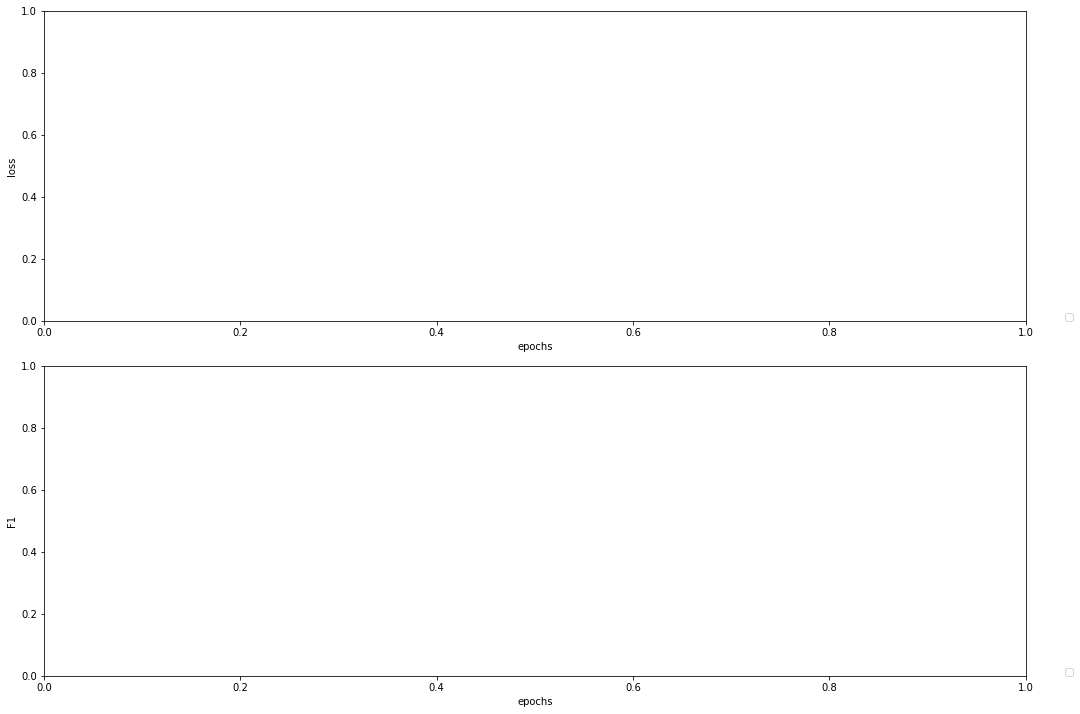

Weights plots are saved in C:\Users\Chiara\Desktop\CoNLL_project\weights.png


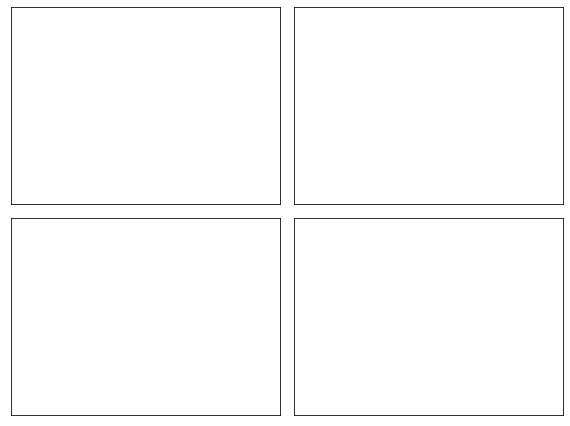

In [15]:
#from flair.visual.training_curves import Plotter
#plotter = Plotter()
#plotter.plot_training_curves(r'CoNLL_project\test.tsv') 
#plotter.plot_weights(r'CoNLL_project\weights.txt')


# CONCLUSION:
And that’s how you train the NER model for custom entities using Flair. It is easy to use, just the data preparation was a bit tedious unlike spaCy, where we have tools for that also(PhraseMatcher, etc). Flair is said to achieve better performance than spaCy for sequence tagging. It will be a good practice to first learn to train NER for custom entities with spaCy and then moving to Flair.

 Sources:
 * difference between spaCy and Flair NER:
 https://medium.com/@sapphireduffy/is-flair-a-suitable-alternative-to-spacy-6f55192bfb01 

* CODE: https://medium.com/thecyphy/training-custom-ner-model-using-flair-df1f9ea9c762

* BEST EMBEDDING + MODEL : https://github.com/flairNLP/flair/blob/master/resources/docs/EXPERIMENTS.md

* BIO ANNOTATION: https://books.google.it/books?id=ankSgwPgOUQC&pg=PA297&lpg=PA297&dq=B-ORG+ner&source=bl&ots=X3S2NDYvIQ&sig=ACfU3U0AVwyUgMoXDnY4sS50xJxa5TuCaw&hl=it&sa=X&ved=2ahUKEwjEp5TVlYHqAhWUOcAKHc7QDx0Q6AEwAXoECAoQAQ#v=onepage&q=B-ORG%20ner&f=false

* https://www.analyticsvidhya.com/blog/2019/02/flair-nlp-library-python/